In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
# Import Libraries
import sys
!{sys.executable} -m pip install pydotplus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image 
import pydotplus

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

## Question and problem definition
เนื่องจากปัญหาที่พบลูกค้าที่ต้องการกู้เงินมากมายในแต่ละปีเป็นเงินจำนวนมากซึ่งในลูกค้าแต่ละประเภทก็จะมีพฤติกรรมที่แต่ต่างกันทั้งลูกค้าคืนเงินตรงเวลาและไม่ตรงเวลาแม้แต่ไม่คืนเลยก็มีซึ่งอาจทำให้ผู้ให้กู้เสียหายจากข้อมูลเราจึงควรแยกกลุ่มผู้กู้และบอกได้ว่าใครที่เราควรให้กู้หรือไม่ให้กู้

## Acquire training and testing data


In [ ]:
# ดึงข้อมูลจากไฟล์มาเก็บไว้ในตัวแปร loan
loan = pd.read_csv("../input/loan-dataset/loan.csv")

# ก็อปปี้ข้อมูลเผื่อไว้
original_loan = loan.copy()
loan.head()

## Wrangle, prepare, cleanse the data

In [ ]:
# ตรวจสอบรูปแบบของข้อมูล
loan.info()

เนื่องจากข้อมูลที่ได้เป็นเดือนอาจจะแคบไป เราอาจสร้าง column ใหม่ให้เก็บค่าเป็นปีก็ได้

In [ ]:
# ดูข้อมูล column 'issue_d'
loan['issue_d'].head()

In [ ]:
# แปลงค่า column 'issue_d' เป็นปี
dt_series = pd.to_datetime(loan['issue_d'])
loan['year'] = dt_series.dt.year
loan['year'].head()

ถ้าที่จะแยกระหว่างผู้กู้ที่ดีและไม่ดีเราควรดูที่สถานะของผู้กู้ถ้าผู้กู้ได้จ่ายหนี้แล้ว แสดงว่าเข้าเป็นผู้กู้ที่ดียกเว้นสถานะ Current เพราะยังไม่รู้ว่าผู้กู้จะชำระครบหรือไม่นั่นเอง

In [ ]:
# ลบสถานะ Current ออกจาก loan_staus และตรวจสอบว่ามีสถานะใดบ้าง
loan = loan[loan['loan_status']!='Current']
loan['loan_status'].value_counts()

จากสถานะของผู้กู้ที่มีเราจะทำการสร้างฟังก์ชั่นเพื่อกรองสถานนะของผู้กู้ที่ไม่ดี

In [ ]:
# กำหนดสถานะผู้กู้ที่ไม่ดี
bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]
# ฟังก์ชั่นแบ่งกลุ่มของผู้กู้เป็น catagory
def loan_condition(status):
    if status in bad_loan:
        return 'Bad'
    else:
        return 'Good'
# ฟังก์ชั่นแบ่งกลุ่มของผู้กู้เป็นตัวเลข  
def loan_condition_num(status):
    if status in bad_loan:
        return 1
    else:
        return 0
# สร้าง column และเรียกใช้ฟังก์ชั่น
loan['loan_condition'] = loan['loan_status'].apply(loan_condition)
loan['loan_condition_num'] = loan['loan_status'].apply(loan_condition_num)
loan.head()

ปัญหาที่เกิดคือข้อมูลมีเยอะเกินไปเราไม่จำเป็นต้องนำข้อมูลทั้งหมดมา train model เพราะจะให้เวลานานมากถ้า gpu ไม่แรงพอ

In [ ]:
# plot ดูจำนวนข้อมูลให้แต่ละปี
sns.countplot(x="year", data=loan);

In [ ]:
# เลือกข้อมูลที่จะใช้ในการวิเคราะห์และทำโมเดล
loan = loan[loan['year']<=2012]
loan['year'].value_counts()

In [ ]:
# plot ดูค่าเฉลี่ยของเงินที่ผู้กู้ยืมไปในแต่ละปี
plt.figure(figsize=(12,8))
sns.barplot('year', 'loan_amnt', data=loan, palette='tab10', ci=None)
plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average loan amount issued', fontsize=14)

จากรูปด้านบนจะเห็นได้ว่ามีการกู้ยืมเงินที่สูงขึ้นในแต่ละปี

In [ ]:
# plot เพื่อดูสัดส่วนสถานะของผู้กู้ยืมทั้งหมด

colors = ["#3791D7", "#D72626"]
labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=20)

loan["loan_condition"].value_counts().plot.pie(autopct='%1.2f%%',  shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)



จากกราฟด้านบนจะแสดงให้เห็นว่าผู้กู้ที่ไม่ดีมี 15.72% ซึ่งถือว่าเยอะมากหากนำมาคิดกับจำนวนเงินที่ให้กู้ยืมไปเราจึงควรจะลดการเกิดผู้กู้ที่ไม่ดีลง

In [ ]:
# plot เพื่อดูจำนวนผู้กู้ที่ไม่ดีในแต่ละปีคิดเป็น%
graph_dims = (24,10)
fig, ax = plt.subplots(figsize=graph_dims)
palette = ["#3791D7"]
sns.barplot(x="year", y="loan_condition_num", data=loan, palette=palette, estimator=lambda x: sum(x)/len(x), ci = None)
ax.set(ylabel="(% of Bad Loans)")

จากกราฟด้านบนจะเห็นได้ว่าผู้กู้ที่ไม่มีลดลงต่ำมากในปี 2009 ซึ่งผมวิเคราะห์เองว่าน่าจะเป็นผลจากหลังวิกฤตในปี 2008 แต่หลังจากปี 2009 ผู้กู้ที่ไม่ดีก็มีแนวโน้มที่จะเพิ่มมากขึ้นในแต่ละปี

In [ ]:
# plot เพื่อดูว่าในเงินที่ให้กู้ในแต่ละประเภทมีผู้กู้ที่ไม่ดีกี่ %
graph_dims = (24,10)
fig, ax = plt.subplots(figsize=graph_dims)

palette = ["#3791D7"]
sns.barplot(x="purpose", y="loan_condition_num", data=loan, palette=palette, estimator=lambda x: sum(x)/len(x), ci = None)
ax.set(ylabel="(% of Bad Loans)")

จากกราฟด้านบนจะเห็นได้ว่าธุรกิจขนาดเล็กมีโอกาศที่จะเป็นผู้กู้ที่ไม่ดีสูง

หลังจากที่เราได้ columns ที่ต้องการแล้วเราควรที่จะเช็ค columns นั้นด้วยว่ามีข้อมูลใดใน columns ได้เสียหายไปหรือไม่

In [ ]:
loan.info()

จากการสำรวจข้อมูล เราจะพบว่าบางข้อมูลสมบูรณ์ บางข้อมูลขาดหายไปบาง บางข้อมูลหายหมดเราต้องดูว่าข้อมูลใหนบางที่เราควรเลือกมาทำโมเดล ซึ่งหากจำเป็นเราต้องใส่ค่าตัวแปรให้กับ columns ที่เสียหาย แต่ถ้า  columns ไม่มีค่าให้เลยเราก็ไม่ควรนำ columns มาทำโมเดล เช่น open_acc_6m หรือ บางข้อมูลที่มีข้อมูลขาดหายมาก เช่น next_pymnt_d ส่วนข้อมูลที่เหลือเราก้มาทำการใส่ค่าให้ครบ

In [ ]:
# ตรวจสอบว่ามี columns มีค่าว่างหรือไม่ ถ้ามีจะเป็น True ถ้าไม่จะเป็น False
loan.replace([np.inf, -np.inf], np.nan)
loan.isnull().any()

เมื่อเราเจอ columns ที่เสียหายแล้วนั้นเราต้องทำการใส่ค่าเข้าไปไม่เช่นนั้นจะเกิด Error ไม่สามารถ Train Model ได้

In [ ]:
# plot เพื่อดูระยะเวลาการจ้างงานของผู้กู้ที่ไม่ดีในแต่ละปี
graph_dims = (24,10)
fig, ax = plt.subplots(figsize=graph_dims)

palette = ["#3791D7"]
sns.barplot(x="emp_length", y="loan_condition_num", data=loan, palette=palette, estimator=lambda x: sum(x)/len(x), ci = None)
ax.set(ylabel="(% of Bad Loans)")

In [ ]:
# plot เพื่อดูระยะเวลาการจ้างงานของผู้กู้ทั้งหมดในแต่ละปี
plt.figure(figsize=(24,10))
palette = ["#3791D7"]
sns.countplot(loan['emp_length'], palette=palette);

In [ ]:
# หาจำนวนของ catagory (emp_length = ระยะเวลาการจ้างงาน)
loan['emp_length'].value_counts()

เราได้สนใจในตัวของ Bad Loan เราควรจะเติมค่า emp_length ที่ว่างด้วยค่า 7 years เพราะว่า เป็นค่าที่จำนวนมากที่สุดในกลุ่ม Bed Loan

In [ ]:
# ฟังก์ชั่นใส่ค่าว่างให้กับ columns
def impute_emp_length(x):
    if pd.isnull(x):
        return '7 years'
    else:
        return x
    
loan['emp_length'] = loan['emp_length'].apply(impute_emp_length)

In [ ]:
# plot เพื่อดู distribution รายได้ในแต่ละปีของผู้กู้
plt.figure(figsize=(24,10))
sns.distplot(loan['annual_inc'])

จากกราฟด้านบนเราควรใช้วิธีหาค่า Missing Value จากการหาค่ามัธยฐาน เนื่องจากคนส่วนใหญ่รายได้อยู่ที่ 60000 และมีบางส่วนที่มีรายได้ถึง 7000000 ถ้าเราหาใช้วิธีในการหาค่าเฉลี่ยอาจทำให้คำตอบที่ได้ผิดพลาดได้

In [ ]:
# หาค่ามัธยฐาน
loan['annual_inc'].median()

In [ ]:
# ฟังก์ชั่นใส่ค่าว่างให้กับ columns
def impute_annual_inc(x):
    if pd.isnull(x):
        return 60000.0
    else:
        return x
    
loan['annual_inc'] = loan['annual_inc'].apply(impute_annual_inc)

In [ ]:
# plot เพื่อดู distribution ของจำนวนการสอบถามข้อมูลใน 6 เดือนที่ผ่านมา (ไม่รวมการสอบถามเกี่ยวกับรถยนต์และการจำนอง)
plt.figure(figsize=(24,10))
sns.distplot(loan['inq_last_6mths'], fit=norm, kde=False)

จากกราฟด้านบนแสดงให้เห็นว่าคนส่วนมากไม่สอบถามข้อมูลทางธุรกรรมหรือสอบถามข้อมูลกันน้อยซึ่งโดยทั่วไป 1 ครั้ง

In [ ]:
# หาค่ามัธยฐาน
loan['inq_last_6mths'].median()

In [ ]:
# ฟังก์ชั่นใส่ค่าว่างให้กับ columns
def impute_inq_last_6mths(x):
    if pd.isnull(x):
        return 1.0
    else:
        return x
    
loan['inq_last_6mths'] = loan['inq_last_6mths'].apply(impute_inq_last_6mths)

In [ ]:
# plot เพื่อดู distribution จำนวนของวงเงินเครดิตคงค้างของผู้ยืม
plt.figure(figsize=(24,10))
sns.distplot(loan['open_acc'], fit=norm, kde=False)

จากกราฟด้านบนแสดงให้เห็นว่าจำนวนวงเงินเครดิตคงค้างของผู้ยืมส่วนมากอยู่ที่ 9 วงเงินซึ่งอาจวิเคราะห์ได้ว่า คนส่วนใหญ่มีวงเครดิตมากทำให้มีปัญหาเรื่องหนี้ได้

In [ ]:
# หาค่ามัธยฐาน
loan['open_acc'].median()

In [ ]:
# ฟังก์ชั่นใส่ค่าว่างให้กับ columns
def impute_open_acc(x):
    if pd.isnull(x):
        return 9.0
    else:
        return x
    
loan['open_acc'] = loan['open_acc'].apply(impute_open_acc)

In [ ]:
# plot เพื่อดู distribution จำนวนวงเงินทั้งหมดในปัจจุบันของผู้กู้
plt.figure(figsize=(24,10))
sns.distplot(loan['total_acc'], fit=norm, kde=False)

จากกราฟด้านบนแสดงให้เห็นว่าจำนวนวงเงินทั้งหมดในปัจจุบันของผู้กู้เฉลี่ยอยู่ประมาณ 21 ซึ่งอาจสรุปได้ว่าคนส่วนมากมีหลายวงเงิน

In [ ]:
# หาค่ามัธยฐาน
loan['total_acc'].median()

In [ ]:
# ฟังก์ชั่นใส่ค่าว่างให้กับ columns
def impute_total_acc(x):
    if pd.isnull(x):
        return 21.0
    else:
        return x
    
loan['total_acc'] = loan['total_acc'].apply(impute_total_acc)

In [ ]:
# plot เพื่อดู distribution จำนวนเร็กคอร์ดที่เสียหาย
plt.figure(figsize=(24,10))
sns.distplot(loan['pub_rec'], fit=norm, kde=False)

In [ ]:
# หาค่ามัธยฐาน
loan['pub_rec'].median()

เนื่องจาก Case ส่วนใหญ่ผู้กู้ที่ดีจะมีการเร็กคอร์ดที่เสียหายเป็น 0 แต่เราสนใจในส่วนของผู้กู้ที่ไม่ดีเราจะลองใส่ค่า 1 ให้กับ columns นี้ (อยากลองส่วนตัว)

In [ ]:
# ฟังก์ชั่นใส่ค่าว่างให้กับ columns
def impute_pub_rec(x):
    if pd.isnull(x):
        return 1.0
    else:
        return x
    
loan['pub_rec'] = loan['pub_rec'].apply(impute_pub_rec)

In [ ]:
# plot เพื่อดู distribution อัตราการใช้ประโยชน์จากหมุนเงินหรือจำนวนเครดิตที่ผู้กู้ใช้เมื่อเทียบกับเครดิตหมุนเวียนทั้งหมดที่มีอยู่
plt.figure(figsize=(24,10))
sns.distplot(loan['revol_util'], fit=norm, kde=False)

จากกราฟด้านบนแสดงให้เห็นว่าอัตราการใช้ประโยชน์จากหมุนเงินของคนส่วนใหญ่ จะอยู่ที่ 56 ซึ่งทำให้เห็นถึงปัญหาว่า ถ้าคนกลุ่มนี้หมุนเงินไม่ไหวอาจเกิดการไม่ชำระหนี้ได้

In [ ]:
# หาค่ามัธยฐาน
loan['revol_util'].median()

In [ ]:
# ฟังก์ชั่นใส่ค่าว่างให้กับ columns
def impute_revol_util(x):
    if pd.isnull(x):
        return 56.8
    else:
        return x
    
loan['revol_util'] = loan['revol_util'].apply(impute_revol_util)

In [ ]:
# plot เพื่อดู distribution dti(อัตราส่วนที่คำนวณโดยใช้การชำระหนี้รายเดือนทั้งหมดของผู้กู้ในภาระหนี้ทั้งหมดไม่รวมการจำนองที่ขอ หารด้วยรายได้ต่อเดือนที่ผู้กู้รายงาน)
plt.figure(figsize=(24,10))
sns.distplot(loan['dti'], fit=norm, kde=False)

จากกราฟด้านบนแสดงให้เห็นเฉลี่ยค่า dti อยู่ที่ 15 โดยประมาณ ซึ่งวิเคราะ์ได้ว่าหนี้หารด้วยเงินเดือนโดยเฉลี่ยแล้วคนส่วยใหญ่ยังมีเงินให้ใช้ต่อเดือนได้สบายๆ

In [ ]:
# หาค่ามัธยฐาน
loan['dti'].median()

In [ ]:
# ฟังก์ชั่นใส่ค่าว่างให้กับ columns
def impute_dti(x):
    if pd.isnull(x):
        return 15.09
    else:
        return x
    
loan['dti'] = loan['dti'].apply(impute_revol_util)

In [ ]:
# ตรวจสอบอีกครั้งว่ามี columns มีค่าว่างหรือไม่
loan.isnull().any()

## Analyze, identify patterns, and explore the data
พอเราแยกกลุ่มผู้กู้ได้แล้วนั้นต่อมาเราจะทำการลบ columns หรือ feature ที่ไม่จำเป็นต่อการนำไปคำนายซึ่งต่อจากนี้จะขอใช้คำว่า feature แทนโดยจะทำการเลือก feature ที่น่ามีผลต่อการทำโมเดล

In [ ]:
# คัดเลือก feature ที่จำเป็นต่อการทำโมเดล
feature_selected = ['purpose', 'verification_status', 'loan_amnt', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc', 'total_acc', 'pub_rec', 'revol_util', 'revol_bal', 'addr_state', 'term', 'loan_condition', 'loan_condition_num']
loan = loan[feature_selected]
loan.head()

พอเราเลือก feature ได้แล้วเราก็ควรเช็คความความสัมพันธ์ของ feature อีกทีเนื่องจากว่าบาง feature บางทีอาจความสัมพันธ์ไปในทิศทางเดียวกันจนเสมือนว่าเป็นสิ่งเดียวกันซึ่งอาจไม่ค่อยมีผลต่อการทำนายมากมาย เราจึงควรตัด feature จำพวกนี้ออกเพื่อไม่ให้การประมวณผลมากจนเกินไป

In [ ]:
# Check correlations
sns.heatmap(loan.corr(), annot=True)

จากความสัมพันธ์ที่ได้จะเห็นว่า feature loan_amnt กับ installment มี correlation มากเราอาจจะเลือกเอาออก 1feature เราควรเลือกใช้ installment เพราะว่าค่าผ่อนจ่ายต่องวดอาจส่งผลทำให้ผู้กู้มีภาระที่ต้องชำระหนี้มากขึ้น น่าจะมีส่วนเกี่ยวข้องกว่า loan_amnt

In [ ]:
# Drop installment
loan = loan.drop(columns=['loan_amnt'])
# Check correlations อีกรอบ
sns.heatmap(loan.corr(), annot=True)

จากHeatmapด้านบนจะเป็นว่า open_acc กับ tota_acc มี correlations ที่สูงพอสมควร แต่ผมคิดว่ายังเพียงพอต่อการนำไป train ทั้งคู่เนื่องจาก open_acc ให้มิติที่เฉพาะเจาะจงในแต่ละ Account แต่ total_acc จะอธิบายโดยรวมของแต่ละ User ซึ่งมีมุมที่น่าสนใจในแต่ละ feature ผมจึงเลือกเก็บ feature ไว้ทั้งคู่

In [ ]:
# ดูข้อมูลโดยรวม
loan.head()

In [ ]:
# check missing value อีกรอบเพื่อความชัว
loan.isnull().any()

In [ ]:
# แปลง categories ในเป็นตัวเลขโดยการทำ one hot encoding 
categories = ['purpose', 'verification_status', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'addr_state', 'term']
raw_model_data = pd.get_dummies(loan.copy(), columns=categories,drop_first=True)

## Model, predict and solve

หลังจากที่เราเตรียมข้อมูลและวิเคราะห์มาเรียบร้อยแล้ว ต่อไปเราต้องทำการ Train Model 

In [ ]:
# กำหนด feature ของ X และ y
X = raw_model_data.drop(columns=['loan_condition', 'loan_condition_num'],axis=1)
y = raw_model_data['loan_condition']

# แบ่ง X_train, X_test, y_train, y_test และกำหนดค่า randon_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

เนื่องจากการ Train Model ใช้เวลา จึงไม่สามารถเปรียบเทียบการปรับ Parameters ให้ดู แต่เราจะสรุปจากการลองทำให้ว่าได้ผลอย่างไรบางในแต่ละโมเดล

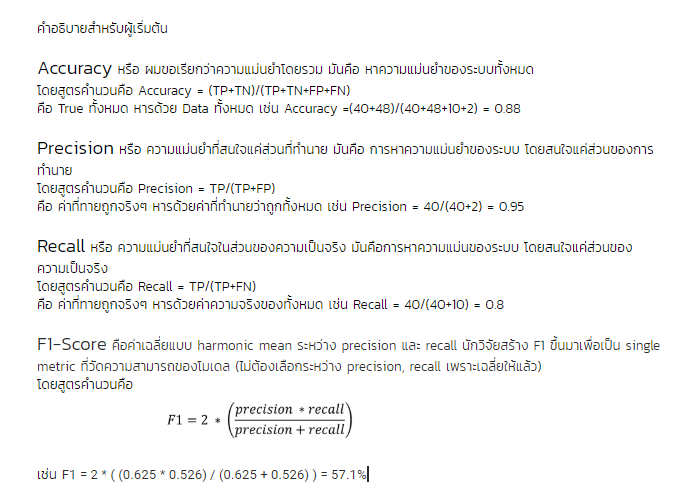


ทำการสร้าง Model โดยใช้วิธีแบบ Random Forest

In [ ]:
# กำหนดค่าของ Forest (n_estimators คือจำนวนของต้นไม้)
random_forest = RandomForestClassifier(n_estimators=600, class_weight="balanced")
# ทำการ Train Model
random_forest.fit(X_train, y_train)
# ทำการ predict 
y_pred = random_forest.predict(X_test)
# แสดง report ของการ prediction
print(classification_report(y_test,y_pred))

In [ ]:
# เก็บค่า accuracy ของ prediction
acc_random_forest = round(accuracy_score(y_test, y_pred) * 100, 2)

จากการลองปรับ Parameters เมื่อปรับ n_estimators = 100 ค่า precistion Bad จะต่ำกว่า n_estimators = 300 และ 600 ค่า recall และ f1 สูงกว่า  n_estimators = 600 แต่จะต่ำกว่า n_estimators = 300 จึงขอสรุปว่า RandomForest ที่ n_estimators = 300 ทำ performance  precision  recall  f1-score ได้ดี และใช้เวลาน้อยกว่า n_estimators = 600

ทำการสร้าง Model โดยใช้วิธีแบบ DecisionTree

In [ ]:
# กำหนดค่าของ DecisionTree 
decision_tree = DecisionTreeClassifier(splitter="best",min_samples_split=10000, class_weight="balanced")
# ทำการ Train Model 
decision_tree.fit(X_train, y_train)
# ทำการ predict 
y_pred = decision_tree.predict(X_test)
# แสดง report ของการ prediction
print(classification_report(y_test,y_pred))

In [ ]:
# เก็บค่า accuracy ของ prediction
acc_decision_tree = round(accuracy_score(y_test, y_pred) * 100, 2)

จากการลองปรับ Parameters พบว่า หากเราเพิ่มตัวอย่างในการแบ่งโหนดยิ่งมาก ค่า recall ของ Bad จะเพิ่มขึ้นอย่างมาก ค่า precision ขึ้นมานิดหน่อย ทำให้ค่า f1 ดีขึ้น แต่ทำให้ค่า accuracy ลดลง ส่วนตัวคิดว่าเราต้องการทราบการทำนายของ Bad มากกว่า good จึงให้ความสัมคัญกับค่า  precision ของ bad ที่เพิ่มขึ้นดีกว่า accuracy

ทำการสร้าง Model โดยใช้วิธีแบบ NearestNeighbors

In [ ]:
# กำหนดค่าของ KNN 
knn = KNeighborsClassifier(n_neighbors = 2, algorithm="auto", leaf_size = 50)
# ทำการ train model
knn.fit(X_train, y_train)
# ทำการ predict 
y_pred = knn.predict(X_test)
# ดูค่า accuracy ของ prediction
print(classification_report(y_test,y_pred))

In [ ]:
# เก็บค่า accuracy ของ prediction
acc_knn = round(accuracy_score(y_test, y_pred) * 100, 2)

จากการลองปรับ Parameters พบว่าจำนวน n_neighbors ที่ดีที่สุดของ data นี้คือ 2 จากการทดลองได้ลองเพิ่ม n_neighbors ดูแล้วโดยคาดว่า  performance จะดีขึ้น แต่กลับกัน ค่า precision เท่าเดิม แต่ค่า recall ลดลงอย่างมากและค่า accuracy เพิ่มขึ้น

ทำการสร้าง Model โดยใช้วิธีแบบ Gaussian Naive Bayes

In [ ]:
# กำหนดค่าของ Gaussian Naive Bayes
gaussian = GaussianNB()
# ทำการ train model
gaussian.fit(X_train, y_train)
# ทำการ predict 
y_pred = gaussian.predict(X_test)
# ดูค่า accuracy ของ prediction
print(classification_report(y_test,y_pred))

In [ ]:
# เก็บค่า accuracy ของ prediction
acc_gaussian = round(accuracy_score(y_test, y_pred) * 100, 2)

จากโมเดลนี้นะเห็นว่า accuracy สูงมาก และค่า precision ของ Bad เราดีเมื่อเทียบกับโมเดลอื่นๆ

ทำการสร้าง Model โดยใช้วิธีแบบ Perceptron

In [ ]:
# กำหนดค่าของ Perceptron
perceptron = Perceptron(max_iter=2000, class_weight="balanced")
# ทำการ train model
perceptron.fit(X_train, y_train)
# ทำการ predict
Y_pred = perceptron.predict(X_test)
# ดูค่า accuracy ของ prediction
print(classification_report(y_test,y_pred))

In [ ]:
# เก็บค่า accuracy ของ prediction
acc_perceptron = round(accuracy_score(y_test, y_pred) * 100, 2)

จากโมเดลนี้นะเห็นว่า accuracy สูงมาก และค่า precision ของ Bad เราดีเทียบเท่ากับโมเดล Gaussian Naive Bayes

ทำการสร้าง Model โดยใช้วิธีแบบ Stochastic Gradient Descent


In [ ]:
# กำหนดค่าของ Stochastic Gradient Descent
sgd = SGDClassifier(l1_ratio=0.16,class_weight="balanced")
# ทำการ train model
sgd.fit(X_train, y_train)
# ทำการ predict
y_pred = sgd.predict(X_test)
# ดูค่า accuracy ของ prediction
print(classification_report(y_test,y_pred))

In [ ]:
# เก็บค่า accuracy ของ prediction
acc_sgd = round(accuracy_score(y_test, y_pred) * 100, 2)

จากการลองปรับ Parameters พบว่าการปรับค่า l1 จะทำให้ precision ดีขึ้น แต่หากปรับมากเกิดไปจะทำให้ accuracy ลดลงอย่างมาก

## Visualize, report, and present the problem solving steps and final solution 

หลังจากเราได้ทำการ สร้างโมเดลแล้วนำมา ทดสอบก็จะพบว่า โมเดลแต่ละแบบจะมี algorithm ที่ต่างกันค่า accuracy ก็อาจต่างกันได้ ซึ่งเราต้องดูว่า algorithm ไหนที่เหมาะสมกับโมเดลของเรามากที่สุด

In [ ]:
# สร้าง dataframe เพื่อเก็บข้อมูล Score
models = pd.DataFrame({
    'Model': ['KNN', 'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Decision Tree'],
    'Score': [acc_knn, acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd,  acc_decision_tree]})

# แสดงผลออกมาโดยเรียงจากมากไปน้อย
models.sort_values(by='Score', ascending=False)

จาก dataframe ด้านบนทำให้เรารู้ว่าโมเดลที่เหมาะสมกับ dataset นี้คือ Random Forest แต่ใน Project นี้จะขอนำเสนอการหาคำตอบโดยวิธีแบบ DecisionTree โดยเราจะ Export ภาพที่จะนำมาอธิบายก่อน

In [ ]:
# Export Decision tree 
dot_data = StringIO()
export_graphviz(decision_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True ,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Export เป็นไฟล์ png
graph.write_png('dtree_pipe.png')
# Export เป็นไฟล์ pdf
graph.write_pdf('dtree_pipe.pdf')
# แสดง Decision tree pipe 
Image(graph.create_png())

เนื่องจากภาพที่แสดงมีขนาดไฟล์ใหญ่มาก ไม่สามารถขยายได้จึงจะขอตัดภาพเพื่อนำมาเป็นตัวอย่างการอธิบายวิธีการหาคำตอบ

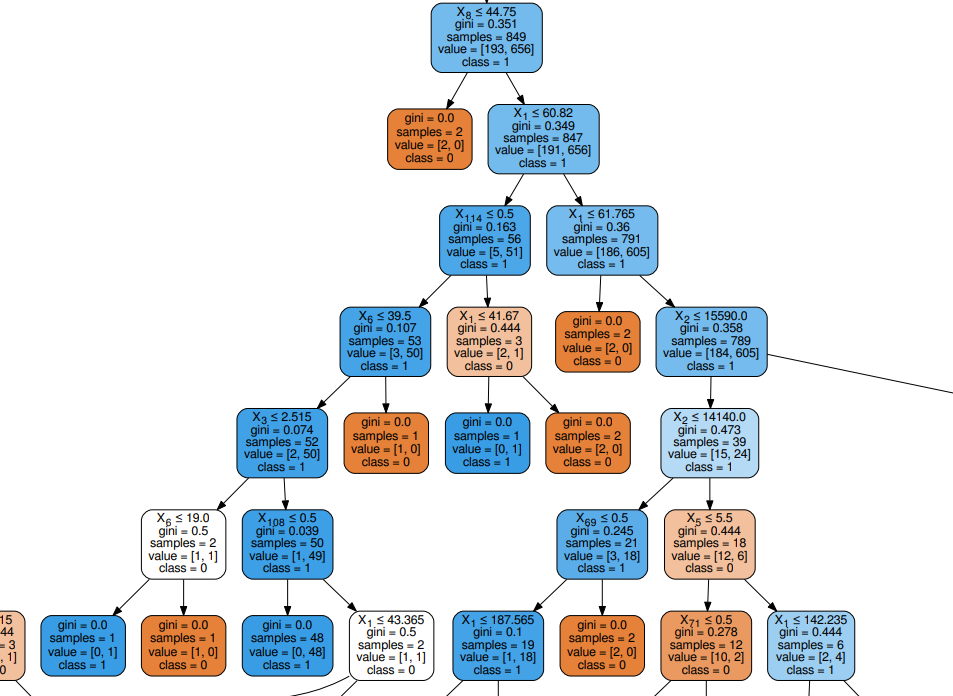

ภาพด้านบนจะแสดงให้เห็นถึงวิธีคิดในการหาคำตอบของคอมพิวเตอร์ โดยจะมี Input เข้ามา ในเงื่อนไขแรกและดูว่ามากกว่าหรือน้อยกว่าค่าในเงื่อนไขนั้นๆ ดั้งนี้
1.  X8 <= 44.75 หมายถึง ถ้า revol_util(อัตราการใช้ประโยชน์จากเงินหมุนหรือจำนวนเครดิตที่ผู้กู้ใช้เมื่อเทียบกับเครดิตหมุนเวียนทั้งหมด) น้อยกว่าหรือเท่ากับ 44.75 หรือไม่ ถ้าไม่จะเป็น 0 นั้นก็คือ เป็นผู้กู้ที่ดี ถ้าไม่จะไปยังเงื่อนไขต่อไป 
2.  X1 <= 60.82 หมายถึง ถ้า installment(การชำระหนี้รายเดือน) น้อยกว่าหรือเท่ากับ 60.82 หรือไม่ ถ้าไม่จะไปอีกเขื่อนไขนึง ถ้าใช่ก็จะไปอีกเขื่อนไขนึงต่อไป โดยเราจะสมมุติว่าใช่
3.  X1 <= 61.765 หมายถึง ถ้า installment(การชำระหนี้รายเดือน) น้อยกว่าหรือเท่ากับ 61.765 หรือไม่ ถ้าไม่จะเป็น 0 นั้นก็คือ เป็นผู้กู้ที่ดี ถ้าใช่จะไปยังเงื่อนไขต่อไป
4.  X2 <= 15590.0 หมายถึง ถ้า annual_inc(รายได้ในแต่ละปีของผู้กู้) น้อยกว่าหรือเท่ากับ 15590.0 หรือไม่ ถ้าไม่จะไปอีกเขื่อนไขนึง ถ้าใช่ก็จะไปอีกเขื่อนไขนึงต่อไป โดยเราจะสมมุติว่าใช่
5.  X2 <= 14140.0 หมายถึง ถ้า annual_inc(รายได้ในแต่ละปีของผู้กู้) น้อยกว่าหรือเท่ากับ 14140.0 หรือไม่ ถ้าไม่จะไปอีกเขื่อนไขนึง ถ้าใช่ก็จะไปอีกเขื่อนไขนึงต่อไป โดยเราจะสมมุติว่าไม่
6.  X69 <= 0.5 หมายถึง ถ้า addr_state_VA(รัฐที่ผู้กู้อาศัยอยู่) น้อยกว่าหรือเท่ากับ 0.5 หรือไม่จะไปยังเงื่อนไขต่อไป แต่ถ้าใช่จะเป็น 0 นั้นก็คือ เป็นผู้กู้ที่ดี โดยเราจะสมมุติว่าใช่ 
7.  model ก็จะทำนายออกมาว่าเป็นผู้กู้ที่ดีนั้นเอง

## Supply or submit the results

จากคำถามและปัญหาที่ตั้งกันไว้ในข้อ 1 เราได้ทำการพิสูจน์ให้เห็นว่า model ของเราสามารถตอบคำถามที่ตั้งต้นไว้ได้

In [ ]:
# ตัวอย่างการ Prediction
print("X_value = %s, Predicted=%s" % (X_test, y_pred[3000]))